In [1]:
import os,glob
import filecmp
import gc
import cv2
import sys
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video
import tifffile as tiff
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
sys.path.append("/kaggle/input/resnet3d")
from resnet3d import generate_model

In [2]:
QUICK_SAVE = False 
mode = 'test'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chkps = [
    '/kaggle/input/train-r18-3d-mosaic/vesuvius-models/Resnet18_3d_fold1_best.pth',
    '/kaggle/input/train-r18-3d-mosaic2-exp1/vesuvius-models/Resnet18_3d_fold2a_best.pth',
    '/kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold2b_best.pth',
    '/kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold1_best.pth',
    '/kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold3_best.pth',
    '/kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold2a_best.pth']
comp_dataset_path='/kaggle/input/vesuvius-challenge-ink-detection/'
TH=0.5
expand=128
size=896
tile_size=size+expand
print('tile_size=',tile_size)
stride=tile_size//2     
BATCH_SIZE = 1
Z_START = 16
Z_DIMS = 32

tile_size= 1024


In [3]:
import cupy as cp
xp = cp

delta_lookup = {
    "xx": xp.array([[1, -2, 1]], dtype=float),
    "yy": xp.array([[1], [-2], [1]], dtype=float),
    "xy": xp.array([[1, -1], [-1, 1]], dtype=float),
}

def operate_derivative(img_shape, pair):
    assert len(img_shape) == 2
    delta = delta_lookup[pair]
    fft = xp.fft.fftn(delta, img_shape)
    return fft * xp.conj(fft)

def soft_threshold(vector, threshold):
    return xp.sign(vector) * xp.maximum(xp.abs(vector) - threshold, 0)

def back_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
    
    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] += 1
    position[dim] += 1
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    temp1 -= temp2
    size[dim] -= 1
    return temp1[0:size[0], 0:size[1]]

def forward_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
        
    size[dim] += 1
    position[dim] += 1

    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] -= 1
    temp2[0:size[0], 0:size[1]] = input_image
    temp1 -= temp2
    size[dim] += 1
    return -temp1[position[0]:size[0], position[1]:size[1]]

def iter_deriv(input_image, b, scale, mu, dim1, dim2):
    g = back_diff(forward_diff(input_image, dim1), dim2)
    d = soft_threshold(g + b, 1 / mu)
    b = b + (g - d)
    L = scale * back_diff(forward_diff(d - b, dim2), dim1)
    return L, b

def iter_xx(*args):
    return iter_deriv(*args, dim1=1, dim2=1)

def iter_yy(*args):
    return iter_deriv(*args, dim1=0, dim2=0)

def iter_xy(*args):
    return iter_deriv(*args, dim1=0, dim2=1)

def iter_sparse(input_image, bsparse, scale, mu):
    d = soft_threshold(input_image + bsparse, 1 / mu)
    bsparse = bsparse + (input_image - d)
    Lsparse = scale * (d - bsparse)
    return Lsparse, bsparse

def denoise_image(input_image, iter_num=100, fidelity=150, sparsity_scale=10, continuity_scale=0.5, mu=1):
    image_size = xp.shape(input_image)
    #print("Initialize denoising")
    norm_array = (
        operate_derivative(image_size, "xx") + 
        operate_derivative(image_size, "yy") + 
        2 * operate_derivative(image_size, "xy")
    )
    norm_array += (fidelity / mu) + sparsity_scale ** 2
    b_arrays = {
        "xx": xp.zeros(image_size, dtype=float),
        "yy": xp.zeros(image_size, dtype=float),
        "xy": xp.zeros(image_size, dtype=float),
        "L1": xp.zeros(image_size, dtype=float),
    }
    g_update = xp.multiply(fidelity / mu, input_image)
    for i in tqdm(range(iter_num), total=iter_num):
        #print(f"Starting iteration {i+1}")
        g_update = xp.fft.fftn(g_update)
        if i == 0:
            g = xp.fft.ifftn(g_update / (fidelity / mu)).real
        else:
            g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
        g_update = xp.multiply((fidelity / mu), input_image)
        
        #print("XX update")
        L, b_arrays["xx"] = iter_xx(g, b_arrays["xx"], continuity_scale, mu)
        g_update += L
        
        #print("YY update")
        L, b_arrays["yy"] = iter_yy(g, b_arrays["yy"], continuity_scale, mu)
        g_update += L
        
        #print("XY update")
        L, b_arrays["xy"] = iter_xy(g, b_arrays["xy"], 2 * continuity_scale, mu)
        g_update += L
        
        #print("L1 update")
        L, b_arrays["L1"] = iter_sparse(g, b_arrays["L1"], sparsity_scale, mu)
        g_update += L
        
    g_update = xp.fft.fftn(g_update)
    g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
    
    g[g < 0] = 0
    g -= g.min()
    g /= g.max()
    return g


In [4]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
class CustomDataset(Dataset):
    def __init__(self, images,  labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        return image
    


In [5]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    count=0
    x1_list = list(range(0, test_images.shape[1]-tile_size+1, stride))
    y1_list = list(range(0, test_images.shape[0]-tile_size+1, stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + tile_size
            x2 = x1 + tile_size
            if np.all(test_images[y1:y2, x1:x2]==0):
                count+=1    
                continue
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list)
    test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)
    return test_loader, xyxys

def read_image(fragment_id):
    images = []

    idxs = range(Z_START,Z_START+Z_DIMS)
    for i in tqdm(idxs):
        image = cv2.imread(f"{comp_dataset_path}/{mode}/{fragment_id}/surface_volume/{i:02}.tif",0)
        pad0 = (tile_size - image.shape[0] % tile_size)
        pad1 = (tile_size - image.shape[1] % tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    return images

In [6]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask
class SegModel(nn.Module):
    def __init__(self,model_depth):
        super().__init__()
        self.encoder = generate_model(model_depth=model_depth, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask

In [7]:
def TTA(x:torch.Tensor,model:nn.Module,tta=True,num_tta=4):
    #x.shape=(batch,1,c,h,w)
    if tta:
        out=[]
        shape=x.shape
        xf1=torch.flip(x, dims=[3])#
        xf2=torch.flip(x, dims=[4])#
        x=[x,*[torch.rot90(x,k=i,dims=(-2,-1)) for i in range(1,num_tta)]]
        for x_ in x:
            out.append(model(x_)) 
        out.append(model(xf1))# 
        out.append(model(xf2)) #
        del x_,xf1,xf2
        gc.collect()
        x=torch.cat(out,dim=0)
        del out
        gc.collect()
        x=torch.sigmoid(x).squeeze(1)
        x=x.reshape(num_tta+2,shape[0],*shape[3:])
        xf = x[4:,:,:,:]
        x =  x[:4,:,:,:]
        x=[torch.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(num_tta)]
        xf1= torch.flip(xf[0], dims=[1])#
        xf2= torch.flip(xf[1], dims=[2])#
        xf=torch.cat([xf1,xf2])
        del xf1,xf2;gc.collect();
        x=torch.stack(x,dim=0)
        x=torch.cat([x,xf.unsqueeze(1)])
        return x.mean(0)
    else :
        x=model(x)
        x=torch.sigmoid(x)
        return x  
class EnsembleModel:
    def __init__(self, use_tta=True):
        self.models = []
        self.use_tta = use_tta

    def __call__(self, x):
        output = [TTA(x,model)
                   for model in self.models]
        output=torch.stack(output,dim=0).mean(0)
        return output
    
    def add_model(self, model):
        self.models.append(model)

def build_ensemble_model(chkps):
    model = EnsembleModel()
    for model_path in chkps:
        if '18' in model_path:
            print('r18',model_path)
            _model=SegModel(18)
        else:
            print('r34',model_path)
            _model = SegModel(34)
        _model.to(device)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state,strict=True)
        _model.eval()
        model.add_model(_model)
    
    return model

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

In [8]:
if mode == 'test':
    fragment_ids = sorted(os.listdir(comp_dataset_path + mode))
else:
    fragment_ids = [3]
print(fragment_ids)    

['a', 'b']


In [9]:
model = build_ensemble_model(chkps)

r18 /kaggle/input/train-r18-3d-mosaic/vesuvius-models/Resnet18_3d_fold1_best.pth
r18 /kaggle/input/train-r18-3d-mosaic2-exp1/vesuvius-models/Resnet18_3d_fold2a_best.pth
r34 /kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold2b_best.pth
r34 /kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold1_best.pth
r34 /kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold3_best.pth
r34 /kaggle/input/train-r34-3d-mosaic/vesuvius-models/Resnet34_3d_fold2a_best.pth


In [10]:
def infer():
    results = []
    for fragment_id in fragment_ids:
        test_loader, xyxys = make_test_dataset(fragment_id)
        binary_mask = cv2.imread(comp_dataset_path + f"{mode}/{fragment_id}/mask.png", 0)
        binary_mask = (binary_mask / 255).astype(int)
        ori_h = binary_mask.shape[0]
        ori_w = binary_mask.shape[1]
        pad0 = (tile_size - binary_mask.shape[0] % tile_size)
        pad1 = (tile_size - binary_mask.shape[1] % tile_size)
        binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
        mask_pred = np.zeros(binary_mask.shape)
        mask_count = np.zeros(binary_mask.shape)
        for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(device)  
            bs = images.size(0)
            with torch.no_grad():
                y_preds = model(images).cpu().numpy()
            start_idx = step*BATCH_SIZE
            end_idx = start_idx + bs
            for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]): 
                mask_pred[y1:y2, x1:x2] += np.pad(crop_center(y_preds[i],size,size),(expand//2,)) 
                mask_count[y1:y2, x1:x2] += np.pad(np.ones((size, size)),(expand//2,)) 
        del test_loader,images      
        gc.collect()
        torch.cuda.empty_cache()
        plt.imshow(mask_count)
        plt.show()
        print(f'mask_count_min: {mask_count.min()}')
        mask_pred /= (mask_count+1e-7)
        
        mask_pred=xp.array(mask_pred)
        mask_pred=denoise_image(mask_pred, iter_num=250)
        mask_pred=mask_pred.get()
        
        mask_pred = mask_pred[:ori_h, :ori_w]
        binary_mask = binary_mask[:ori_h, :ori_w]
        mask_pred = (mask_pred >= TH).astype(int)
        mask_pred *= binary_mask 
        plt.imshow(mask_pred)
        plt.show()    
        inklabels_rle = rle(mask_pred) 
        results.append((fragment_id, inklabels_rle))    
        del mask_pred, mask_count,y_preds,binary_mask,inklabels_rle
        gc.collect()
        torch.cuda.empty_cache()
    return results

100%|██████████| 58/58 [1:25:41<00:00, 88.64s/it]


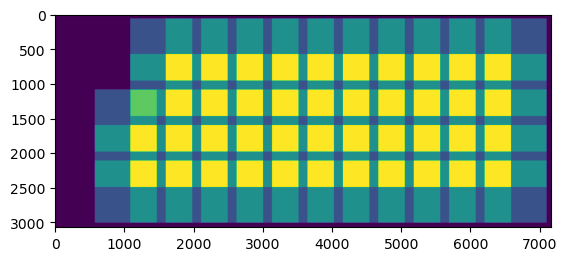

mask_count_min: 0.0


100%|██████████| 250/250 [00:32<00:00,  7.79it/s]


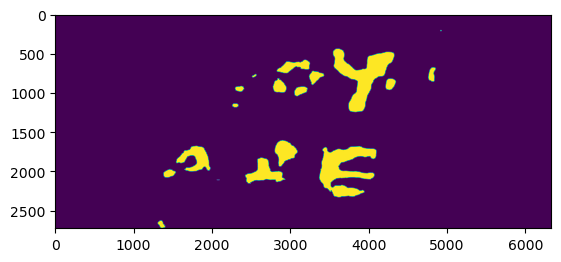

100%|██████████| 94/94 [2:18:46<00:00, 88.58s/it]


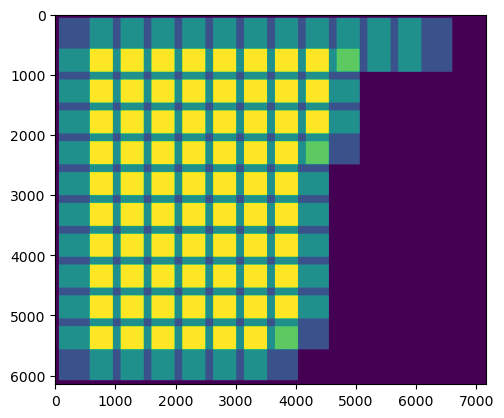

mask_count_min: 0.0


100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


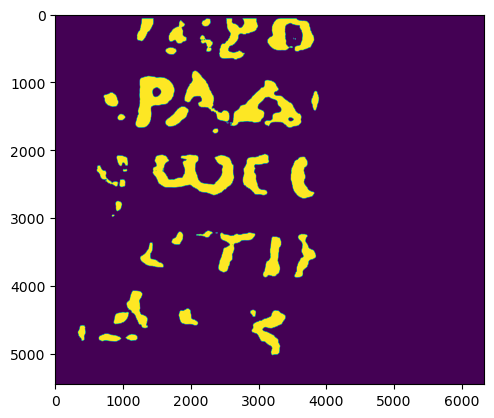

In [11]:
sample_submission_flag = filecmp.cmp(
    "../input/vesuvius-challenge-ink-detection/test/a/surface_volume/00.tif",
    "../input/vcid-file-check/00.tif",
    shallow=True
)

if sample_submission_flag and QUICK_SAVE:
    df_sub = pd.read_csv("../input/vesuvius-challenge-ink-detection/sample_submission.csv")
    df_sub.to_csv("submission.csv", index=False)
    print('Quiq save')
    print(df_sub)
else:
    results=infer()
    sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
    sample_sub = pd.read_csv(comp_dataset_path + 'sample_submission.csv')
    sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
    sample_sub.to_csv("submission.csv", index=False)
    sample_sub
    